In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU ok')
else:
    print('GPU not ok, CPU')

GPU ok


In [2]:
import random
import numpy as np

seed = 42

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

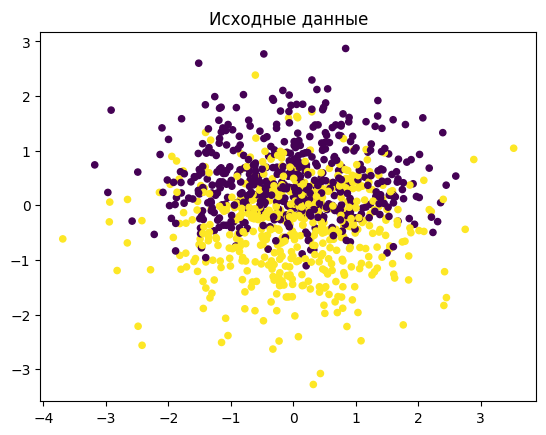

In [3]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=1000)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.title('Исходные данные')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
from tensorflow.keras import layers, models


def build_model(optimizer):
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'Adam': tf.keras.optimizers.Adam(),
    'RMSProp': tf.keras.optimizers.RMSprop()
}

histories_no_dropout = {}
metrics_no_dropout = {}

for name, opt in optimizers.items():
    print(f'обучение без дропаута: {name}')
    model = build_model(opt)
    history = model.fit(
        X_train, y_train,
        epochs=15,
        verbose=0,
        validation_data=(X_test, y_test)
    )
    histories_no_dropout[name] = history

    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    metrics_no_dropout[name] = {
        'acc': accuracy_score(y_test, y_pred),
        'prec': precision_score(y_test, y_pred),
        'rec': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }


обучение без дропаута: SGD
обучение без дропаута: Adam
обучение без дропаута: RMSProp


In [7]:
def build_model_dropout(optimizer):
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
histories_dropout = {}
metrics_dropout = {}

for name, opt in optimizers.items():
    print(f'обучение с дропаутом: {name}')
    model = build_model_dropout(opt)
    history = model.fit(
        X_train, y_train,
        epochs=15,
        verbose=0,
        validation_data=(X_test, y_test)
    )
    histories_dropout[name] = history

    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    metrics_dropout[name] = {
        'acc': accuracy_score(y_test, y_pred),
        'prec': precision_score(y_test, y_pred),
        'rec': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }


обучение с дропаутом: SGD
обучение с дропаутом: Adam
обучение с дропаутом: RMSProp


In [9]:
print('\nметрики без dropout')
for k, v in metrics_no_dropout.items():
    print(f"{k}: acc {v['acc']:.3f}, prec {v['prec']:.3f}, rec {v['rec']:.3f}, f1 {v['f1']:.3f}")

print('\nметрики с dropout')
for k, v in metrics_dropout.items():
    print(f"{k}: acc {v['acc']:.3f}, prec {v['prec']:.3f}, rec {v['rec']:.3f}, f1 {v['f1']:.3f}")



метрики без dropout
SGD: acc 0.825, prec 0.875, rec 0.785, f1 0.828
Adam: acc 0.845, prec 0.888, rec 0.813, f1 0.849
RMSProp: acc 0.830, prec 0.892, rec 0.776, f1 0.830

метрики с dropout
SGD: acc 0.820, prec 0.866, rec 0.785, f1 0.824
Adam: acc 0.875, prec 0.910, rec 0.850, f1 0.879
RMSProp: acc 0.830, prec 0.910, rec 0.757, f1 0.827


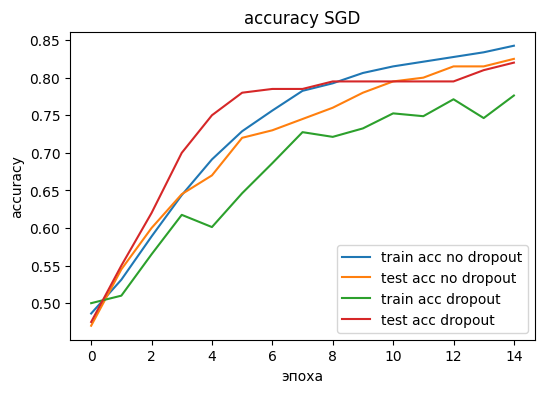

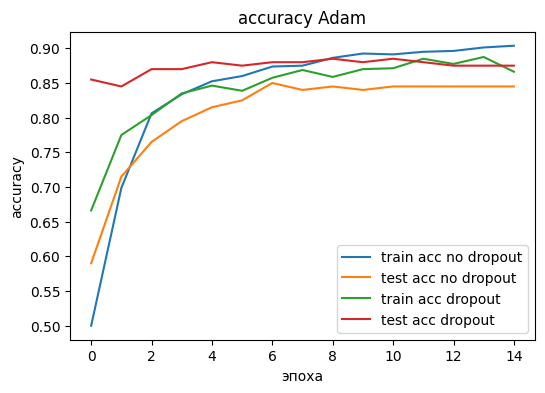

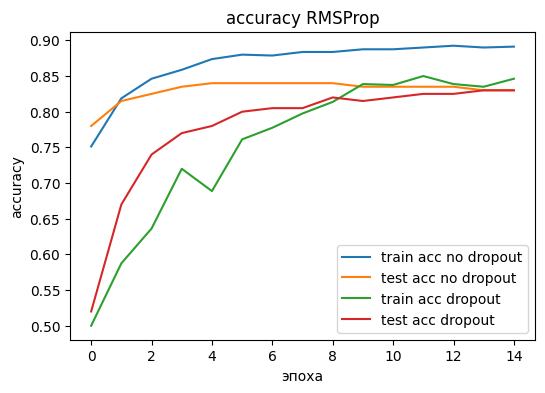

In [10]:
import matplotlib.pyplot as plt

for name in optimizers.keys():
    plt.figure(figsize=(6, 4))

    plt.plot(histories_no_dropout[name].history['accuracy'], label='train acc no dropout')
    plt.plot(histories_no_dropout[name].history['val_accuracy'], label='test acc no dropout')

    plt.plot(histories_dropout[name].history['accuracy'], label='train acc dropout')
    plt.plot(histories_dropout[name].history['val_accuracy'], label='test acc dropout')

    plt.title(f'accuracy {name}')
    plt.xlabel('эпоха')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


* все оптимизаторы показывают хорошую точность
* sgd учится медленно, но train и val почти совпадают, переобучения почти нет
* adam обучается быстрее, val выше train в середине, но разрыв небольшой
* rmsprop тоже стабильный, но чуть уступает adam
* dropout снижает train accuracy, но делает val ровнее, линии train и val ближе
* в целом dropout делает модель спокойнее и уменьшает риск переобучения
